In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\Spark\\spark-3.1.2-bin-hadoop3.2'

# Default Parameters

In [2]:
filename = "bank-full.csv"
target_variable_name = "y"

# Load Dataset

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=';')
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

# Length of the data

In [4]:
df.count()

45211

# Describe data

In [5]:
df.describe().toPandas()

,summary,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
1,mean,40.93621021432837,None,None,None,None,1362.2720576850766,None,None,None,15.80641879188693,None,258.1630797814691,2.763840658246887,40.19782796222158,0.5803233726305546,None,None
2,stddev,10.618762040975401,None,None,None,None,3044.7658291685243,None,None,None,8.322476153044589,None,257.5278122651712,3.0980208832791813,100.12874599059818,2.3034410449312164,None,None
3,min,18,admin.,divorced,primary,no,-8019,no,no,cellular,1,apr,0,1,-1,0,failure,no
4,max,95,unknown,single,unknown,yes,102127,yes,yes,unknown,31,sep,4918,63,871,275,unknown,yes


# Check Data types of each column

In [6]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string')]

In [7]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



# Count the records by group

In [8]:
df.groupBy('education').count().show()

+---------+-----+
|education|count|
+---------+-----+
|  unknown| 1857|
| tertiary|13301|
|secondary|23202|
|  primary| 6851|
+---------+-----+



# Count the records by target

In [9]:
df.groupBy(target_variable_name).count().show()

+---+-----+
|  y|count|
+---+-----+
| no|39922|
|yes| 5289|
+---+-----+



# Group by Multiple columns

In [10]:
df.groupBy(['education',target_variable_name]).count().show()

+---------+---+-----+
|education|  y|count|
+---------+---+-----+
|  unknown| no| 1605|
| tertiary| no|11305|
|secondary| no|20752|
|  unknown|yes|  252|
|  primary| no| 6260|
|  primary|yes|  591|
|secondary|yes| 2450|
| tertiary|yes| 1996|
+---------+---+-----+



In [11]:
from pyspark.sql.functions import *
df.groupBy(target_variable_name).agg({'balance':'avg', 'age': 'avg'}).show()

+---+------------------+------------------+
|  y|      avg(balance)|          avg(age)|
+---+------------------+------------------+
| no|1303.7149691899203| 40.83898602274435|
|yes|1804.2679145396105|41.670069956513515|
+---+------------------+------------------+



# Identify variable types

In [12]:
def variable_type(df):
    
    vars_list = df.dtypes
    char_vars = []
    num_vars = []
    for i in vars_list:
        if i[1] in ('string'):
            char_vars.append(i[0])
        else:
            num_vars.append(i[0])
    
    return char_vars, num_vars

In [13]:
char_vars, num_vars = variable_type(df)

In [14]:
char_vars

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [15]:
num_vars

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# StringIndexer

In [16]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

def category_to_index(df, char_vars):
    
    char_df = df.select(char_vars)
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid="keep") for c in char_df.columns]
    pipeline = Pipeline(stages=indexers)
    char_labels = pipeline.fit(char_df)
    df = char_labels.transform(df)
    return df, char_labels

In [17]:
df, char_labels = category_to_index(df, char_vars)

In [18]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('job_index', 'double'),
 ('marital_index', 'double'),
 ('education_index', 'double'),
 ('default_index', 'double'),
 ('housing_index', 'double'),
 ('loan_index', 'double'),
 ('contact_index', 'double'),
 ('month_index', 'double'),
 ('poutcome_index', 'double'),
 ('y_index', 'double')]

In [19]:
df = df.select([c for c in df.columns if c not in char_vars])

In [20]:
def rename_columns(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([col(c).alias(mapping.get(c, c)) for c in df.columns])
    return df

In [21]:
df = rename_columns(df, char_vars)

In [22]:
df.dtypes

[('age', 'int'),
 ('balance', 'int'),
 ('day', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('job', 'double'),
 ('marital', 'double'),
 ('education', 'double'),
 ('default', 'double'),
 ('housing', 'double'),
 ('loan', 'double'),
 ('contact', 'double'),
 ('month', 'double'),
 ('poutcome', 'double'),
 ('y', 'double')]

In [23]:
df.groupBy('y').count().show()

+---+-----+
|  y|count|
+---+-----+
|0.0|39922|
|1.0| 5289|
+---+-----+



# Assemble input vectors

In [24]:
from pyspark.ml.feature import VectorAssembler

#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features'] + features_list
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df

In [25]:
#exclude target variable and select all other feature vectors
features_list = df.columns
#features_list = char_vars #this option is used only for ChiSqselector
features_list.remove(target_variable_name)

In [26]:
features_list

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [27]:
# apply the function on our dataframe
df = assemble_vectors(df, features_list, target_variable_name)

In [28]:
df.show(5, False)

+---+----------------------------------------------------------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+
|y  |features                                                              |age|balance|day|duration|campaign|pdays|previous|job |marital|education|default|housing|loan|contact|month|poutcome|
+---+----------------------------------------------------------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+
|0.0|(16,[0,1,2,3,4,5,7,9,13],[58.0,2143.0,5.0,261.0,1.0,-1.0,1.0,1.0,1.0])|58 |2143   |5  |261     |1       |-1   |0       |1.0 |0.0    |1.0      |0.0    |0.0    |0.0 |1.0    |0.0  |0.0     |
|0.0|(16,[0,1,2,3,4,5,7,8,13],[44.0,29.0,5.0,151.0,1.0,-1.0,2.0,1.0,1.0])  |44 |29     |5  |151     |1       |-1   |0       |2.0 |1.0    |0.0      |0.0    |0.0    |0.0 |1.0    |0.0  |0.0     |
|0.0|(16,[0,1,2,3,4,5,7,12,13],[33.

In [29]:
df.select('features').show(5, False)

+----------------------------------------------------------------------+
|features                                                              |
+----------------------------------------------------------------------+
|(16,[0,1,2,3,4,5,7,9,13],[58.0,2143.0,5.0,261.0,1.0,-1.0,1.0,1.0,1.0])|
|(16,[0,1,2,3,4,5,7,8,13],[44.0,29.0,5.0,151.0,1.0,-1.0,2.0,1.0,1.0])  |
|(16,[0,1,2,3,4,5,7,12,13],[33.0,2.0,5.0,76.0,1.0,-1.0,7.0,1.0,1.0])   |
|(16,[0,1,2,3,4,5,9,13],[47.0,1506.0,5.0,92.0,1.0,-1.0,3.0,1.0])       |
|[33.0,1.0,5.0,198.0,1.0,-1.0,0.0,11.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0]|
+----------------------------------------------------------------------+
only showing top 5 rows



# Scaled input vectors assembled

In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

#assemble and scale individual columns to one column - 'features2'
def scaled_assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='assembled_features')
    # scaling here:
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol='features2')
    stages = [assembler, scaler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features2'] + features_list
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    scaleAssembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = scaleAssembleModel.transform(df).select(selectedCols)
    return df

In [31]:
features_list = df.columns
features_list.remove(target_variable_name)

In [32]:
df = scaled_assemble_vectors(df, features_list, target_variable_name)

In [33]:
df.show(5)

+---+--------------------+--------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+
|  y|           features2|            features|age|balance|day|duration|campaign|pdays|previous| job|marital|education|default|housing|loan|contact|month|poutcome|
+---+--------------------+--------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+
|0.0|(32,[0,1,2,3,4,5,...|(16,[0,1,2,3,4,5,...| 58|   2143|  5|     261|       1|   -1|       0| 1.0|    0.0|      1.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
|0.0|(32,[0,1,2,3,4,5,...|(16,[0,1,2,3,4,5,...| 44|     29|  5|     151|       1|   -1|       0| 2.0|    1.0|      0.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
|0.0|(32,[0,1,2,3,4,5,...|(16,[0,1,2,3,4,5,...| 33|      2|  5|      76|       1|   -1|       0| 7.0|    0.0|      0.0|    0.0|    0.0| 1.0|    1.0|  0.0|     0.0|
|0.0|(32,[0,1,2,

In [34]:
df.select('features').show(5, False)

+----------------------------------------------------------------------+
|features                                                              |
+----------------------------------------------------------------------+
|(16,[0,1,2,3,4,5,7,9,13],[58.0,2143.0,5.0,261.0,1.0,-1.0,1.0,1.0,1.0])|
|(16,[0,1,2,3,4,5,7,8,13],[44.0,29.0,5.0,151.0,1.0,-1.0,2.0,1.0,1.0])  |
|(16,[0,1,2,3,4,5,7,12,13],[33.0,2.0,5.0,76.0,1.0,-1.0,7.0,1.0,1.0])   |
|(16,[0,1,2,3,4,5,9,13],[47.0,1506.0,5.0,92.0,1.0,-1.0,3.0,1.0])       |
|[33.0,1.0,5.0,198.0,1.0,-1.0,0.0,11.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0]|
+----------------------------------------------------------------------+
only showing top 5 rows



# Principal Component analysis

### Without Scaling

In [35]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df)

result = model.transform(df).select("pcaFeatures")
result.show(truncate=False)

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-2143.4953647735806,-257.0420740676509,1.2449712753045807] |
|[-29.29226175164622,-150.92888640669173,1.0493026899277984] |
|[-2.150889773941845,-75.98191250436618,1.076065195538016]   |
|[-1506.1823305908113,-89.21547154672724,1.2683999536975388] |
|[-1.3750908349447704,-197.98356175494834,0.9892427009814176]|
|[-231.26679712386607,-138.56034919503722,1.0576960891394662]|
|[-447.4072782675638,-216.16541383839757,1.0066666548029033] |
|[-2.7123264447441384,-379.9785828164356,0.875150469836411]  |
|[-121.11144848214039,-49.756360259707854,1.1725853591922941]|
|[-593.1146061641073,-53.89364261832045,1.1817022732261329]  |
|[-270.4212341323415,-221.4869966182793,1.0170824073203284]  |
|[-390.2608167665407,-136.27016909339142,1.0625336862698371] |
|[-6.967616100129074,-516.9674558248698,0.8003545768065

In [36]:
model.pc.toArray()

array([[-3.41021399e-04,  2.79524640e-04,  2.58353293e-03],
       [-9.99998245e-01,  1.83654726e-03,  1.13892524e-04],
       [-1.22934480e-05,  9.79995613e-04,  7.79347982e-03],
       [-1.83671689e-03, -9.99996986e-01, -7.36955549e-04],
       [ 1.48468991e-05,  1.01391994e-03,  2.75121381e-03],
       [-1.13085547e-04,  7.49207153e-04, -9.99889046e-01],
       [-1.26153895e-05, -6.36100089e-06, -1.04654388e-02],
       [-1.78789640e-05, -4.11817349e-05,  5.51411389e-04],
       [ 6.41085932e-06, -5.23364803e-05, -1.45349520e-04],
       [-1.11185424e-05,  1.30366514e-05,  2.01500982e-04],
       [ 2.91665702e-06,  4.42643869e-06,  3.95562163e-05],
       [-1.12221341e-05,  1.26153926e-05,  6.17569266e-04],
       [ 1.01623400e-05,  1.50687571e-05,  8.23933054e-05],
       [-5.68377754e-07,  6.95393403e-05,  1.03951369e-03],
       [-7.60886236e-05, -1.16754927e-04, -3.24662847e-03],
       [-8.55162111e-06, -6.01853226e-05, -4.94522998e-03]])

In [37]:
model.explainedVariance

DenseVector([0.9918, 0.0071, 0.0011])

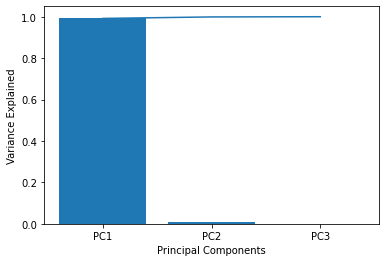

In [38]:
import matplotlib.pyplot as plt
import numpy as np
x = []
for i in range(0, len(model.explainedVariance)):
    x.append('PC' + str(i + 1))
y = np.array(model.explainedVariance)
z = np.cumsum(model.explainedVariance)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.bar(x, y)
plt.plot(x, z)

### With Scaling

In [39]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

pca = PCA(k=3, inputCol="features2", outputCol="pcaFeatures")
model = pca.fit(df)

result = model.transform(df).select("pcaFeatures")
result.show(truncate=False)

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-0.656780883522954,4.312194871151715,-4.393764846983172]   |
|[-0.5905533920181225,2.7430023739084834,-2.0129736282039534]|
|[-0.7923309293106096,2.4285178222008144,-1.4128758397236354]|
|[-0.7779852947452655,4.298302632063681,-5.322505502931134]  |
|[-0.5280039534403727,6.559141503668741,-1.4081500208402007] |
|[-0.7028277580738278,2.709340734232335,-3.2263556470672334] |
|[-0.8104872327792485,1.429021001342883,-1.619935441335167]  |
|[-0.9758735335487514,2.862044859013722,0.4335559756407308]  |
|[-0.7126916038564428,5.1756377163943945,-4.531453571471411] |
|[-0.5939132026125427,2.746785250427306,-2.0709944257211284] |
|[-0.48367202786592667,2.584502296303892,-0.8133472106611472]|
|[-0.5574665926507092,2.079820030405431,-1.169526629998768]  |
|[-0.6052039081601734,3.4943812853157916,-3.06065582479

In [40]:
model.pc.toArray()

array([[-0.004235  ,  0.31145353, -0.26369491],
       [ 0.03423185,  0.1928538 , -0.09378775],
       [-0.08159571,  0.00735314, -0.01093587],
       [ 0.02258652,  0.01207569,  0.09783498],
       [-0.09750453, -0.01505392, -0.13223208],
       [ 0.38906235, -0.10676363, -0.10055607],
       [ 0.32421309, -0.05649281, -0.11841411],
       [ 0.02062378,  0.22986117,  0.17519785],
       [ 0.02465328, -0.06652983,  0.30496446],
       [-0.01528388,  0.19502562, -0.27178677],
       [-0.03590056, -0.0599626 ,  0.08395041],
       [ 0.00319029,  0.38740709,  0.17909603],
       [-0.03722061, -0.13065229,  0.06100361],
       [-0.15724617, -0.00297912, -0.30082714],
       [ 0.18201491,  0.29037062,  0.1860691 ],
       [ 0.40477716, -0.02040979, -0.0694982 ],
       [-0.004235  ,  0.31145353, -0.26369491],
       [ 0.03423185,  0.1928538 , -0.09378775],
       [-0.08159571,  0.00735314, -0.01093587],
       [ 0.02258652,  0.01207569,  0.09783498],
       [-0.09750453, -0.01505392, -0.132

In [41]:
model.explainedVariance

DenseVector([0.1434, 0.0987, 0.0787])

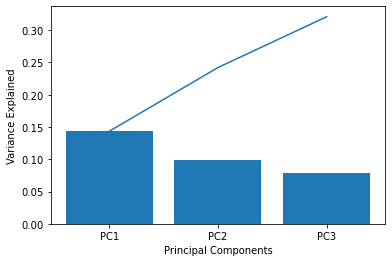

In [42]:
import matplotlib.pyplot as plt
import numpy as np
x = []
for i in range(0, len(model.explainedVariance)):
    x.append('PC' + str(i + 1))
y = np.array(model.explainedVariance)
z = np.cumsum(model.explainedVariance)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.bar(x, y)
plt.plot(x, z)

# ChiSq selector

In [43]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

selector = ChiSqSelector(numTopFeatures=6, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="y")

chi_selector = selector.fit(df)
    
result = chi_selector.transform(df)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
print("Selected Indices: ", chi_selector.selectedFeatures)
result.show(5)

ChiSqSelector output with top 6 features selected
Selected Indices:  [0, 1, 2, 3, 4, 5]
+---+--------------------+--------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+--------------------+
|  y|           features2|            features|age|balance|day|duration|campaign|pdays|previous| job|marital|education|default|housing|loan|contact|month|poutcome|    selectedFeatures|
+---+--------------------+--------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+--------------------+
|0.0|(32,[0,1,2,3,4,5,...|(16,[0,1,2,3,4,5,...| 58|   2143|  5|     261|       1|   -1|       0| 1.0|    0.0|      1.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|(6,[0,1,2,3,4,5],...|
|0.0|(32,[0,1,2,3,4,5,...|(16,[0,1,2,3,4,5,...| 44|     29|  5|     151|       1|   -1|       0| 2.0|    1.0|      0.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|(6,[0,1,2

In [44]:
chi_selector.selectedFeatures

[0, 1, 2, 3, 4, 5]

In [45]:
spark.stop()

### Great Job!!